In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps, quad
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
from datetime import datetime
import pytz

pi = np.pi

# Welcome to the Gross-Pitaevskii solver

This code is designed to olve the Gross-Pitaevskii equation for a Bose-Einstein condensate confined in a 3d isotropic harmonic potential. The numerical approach is based on the Crank-Nicolson method, incorporating an imaginary time evolution to obtain the ground state of the system.

Before running the simulation, you may need to define the relevant global parameters, like the number of particles of the system `N`, the s-wave scattering length `As`, the timestep and grid spacing, `dt`, `dr`, or the final point of the grid `r_max`. Since the density profile rapidly decays to zero at sufficiently large values of r, a `r_max` value of roughly 2-5 times the associated Thomas-Fermi lengthscale should be enough for most of the computations, though this may vary depending on the initial conditions.

The parameters are in harmonic oscillator units, such that $\hbar=m=\omega=1$.


In [7]:
#global parameters
N = 1e4 #number of particles
As=0.00433 #s-wave scattering length. For As=0 we recover the known ground state solution of the quantum h.o
g = 4.*pi*As*N #interaction strength
dt = 1e-4 #timestep
dr=0.05 #grid spacing
#be careful for what values of dt and dr you choose, since some of them may yield numerical instabilities.
#Its important that, when the error gets smaller than the tolerance parameter, you check the "errorvirial" parameter to see if its small enough to consider
#the results as correct, or otherwise is large enough to discard them and run the simulation again with other dt,dr parameters

#Thomas-Fermi parameters muTF and rTF
muTF = 0.5*(15*As*N)**(2./5.)
rTF = np.sqrt(2.*muTF)
print("Thomas-Fermi length is: ", rTF)

r_max = 2*rTF

Ngrid = int(r_max/dr)
r = np.linspace(0.,r_max,Ngrid+1)[1:] #we avoid r=0

Niter = 100000 #maximum number of timesteps allowed (safer)

Thomas-Fermi length is:  3.6518743897555477


The computation time depends highly on the number of grid points or the timesteps needed to achieve the tolerance wanted. It may take from a few seconds to several minutes or even a few hours, in the most extreme cases, to obtain the final results.

The ground state of the system is obtained through an iterative procedure based on the Crank-Nicolson implicit method, which solves for the radial part of the wave function $P(r)$ at each time step, where $\psi(r) = \frac{P(r)}{r}\frac{1}{\sqrt{4\pi}}$, and ending the loop when the "error" made, which is defined as $\varepsilon = \sum_i|P_i - P_i^\text{old}|$, where $(i\in\text{grid})$, gets smaller than the tolerance parameter `tol`. When the simulation ends, the vectors `r` and `P` will be written in a file called "r_P(As=...)(N=...)... .dat".

The last part of the code will be the plotting of the density profile compared with that obtained from the Thomas-Fermi approximation. For this, we may read the data of the file "r_P... .dat" and assign it to the vectors `r` and `P`, for later plotting and calculation of the desired energies per particle: total, kinetic, potential, interaction, and the chemical potential, as well as testing that the virial theorem is fulfilled within a certain tolerance. These two parts; the time evolution and the plotting, are separated since one might only want the plotting part without having to run the whole time evolution.

If you have any questions, suggestions, or issues regarding the solver, feel free to contact me at matteomarrone27@gmail.com.

In [8]:
#TIME EVOLUTION PART OF THE CODE:

#We get the actual time of the start of the computation (change location from Europe/Madrid to whichever fits you best) 
tz = pytz.timezone('Europe/Madrid')
timenow = datetime.now(tz)
print("Current time in Barcelona: ", timenow.strftime("%H:%M:%S"))

#harmonic potential
V = 0.5*(r**2.)

#laplacian matrix in finite differences
D2 = (-2.*np.eye(Ngrid) + np.eye(Ngrid, k=1) + np.eye(Ngrid, k=-1))/(dr**2.)

#we construct the P radial function of the initial wave function, where psi = (P/r)/sqrt(4pi)
P = r*np.exp(-0.5*r**2.)
P  /= np.sqrt(simps(P**2, r)) #normalization

#imaginary time evolution
tol = 1e-6
error = 1.0
errorVirial = 1.
timesteps = 0

start_time = time.time()

while error>tol and timesteps<Niter:
    P_old = P.copy()

    psi = P/(r*np.sqrt(4.*pi)) #wave function
    G = g*np.abs(psi)**2. #non linear term

    #We construct the Cranc Nicolson matrices
    A = np.eye(Ngrid) + (dt/2.)*(-0.5*D2 +np.diag(V+G))
    B = np.eye(Ngrid) - (dt/2.)*(-0.5*D2 +np.diag(V+G))

    #solve the system
    P = np.linalg.solve(A, B @ P)
    P /= np.sqrt(simps(P**2, r)) #renormalize

    #calculate the density
    psi = P/(r*np.sqrt(4.*pi))
    dens = np.abs(psi)**2
    #we calculate the expected values of the energies
    Ekin = simps(-0.5*P*np.dot(D2,P), r)
    Epot = simps(V*P**2, r)
    Eint = simps(0.5*g*np.abs(psi)**4*(4.*pi*r**2), r)

    #compute error
    error = np.sum(np.abs(P-P_old))
    errorVirial = np.abs(-2*Epot+2*Ekin+3*Eint)
    timesteps+=1

    if timesteps % 400 == 0:
        print(f"step: {timesteps}, error: {error:.6e}, errorVirial: {errorVirial:.6e}")

print("Computation time (seconds) is: ", time.time()-start_time)
print("--------------------------------")

Current time in Barcelona:  21:23:49
step: 400, error: 1.841282e-02, errorVirial: 1.790622e+01
step: 800, error: 1.105846e-02, errorVirial: 1.199982e+01
step: 1200, error: 7.897189e-03, errorVirial: 9.054833e+00
step: 1600, error: 6.093025e-03, errorVirial: 7.189381e+00
step: 2000, error: 4.900369e-03, errorVirial: 5.869335e+00
step: 2400, error: 4.045484e-03, errorVirial: 4.874643e+00
step: 2800, error: 3.397649e-03, errorVirial: 4.094843e+00
step: 3200, error: 2.886992e-03, errorVirial: 3.467046e+00
step: 3600, error: 2.475163e-03, errorVirial: 2.952134e+00
step: 4000, error: 2.134286e-03, errorVirial: 2.524119e+00
step: 4400, error: 1.848177e-03, errorVirial: 2.164820e+00
step: 4800, error: 1.606118e-03, errorVirial: 1.860987e+00
step: 5200, error: 1.398518e-03, errorVirial: 1.602637e+00
step: 5600, error: 1.219025e-03, errorVirial: 1.382039e+00
step: 6000, error: 1.064472e-03, errorVirial: 1.193076e+00
step: 6400, error: 9.296161e-04, errorVirial: 1.030813e+00
step: 6800, error: 8.

In [9]:
#we write the computed data to the file
filename = f"r_P_(As={As})(N={N})(dt={dt})(dr={dr})(rmax={r_max})(tol={tol}).dat"
f = open(filename, 'w')

for i in range(len(r)):
    f.write(str(r[i])+" "+str(P[i]))
    f.write("\n")

f.close()

Is the numerical solution normalized to 1?:  0.9999999999999998
Ekin:  0.24058429956346972 Epot:  2.976728187782734 Eint:  1.824431102602352 Etotal:  5.041743589948556
virial?:  0.0010055313685279899
chem potential:  6.866174692550908
tf normalization:  1.0


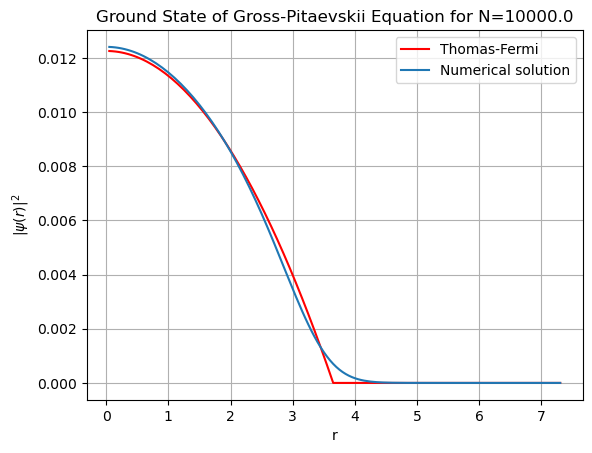

In [10]:
#we read the computed data to plot it
with open(filename) as f:
    lines = f.readlines()
    r = np.array([line.split()[0] for line in lines],dtype=float)
    P = np.array([line.split()[1] for line in lines],dtype=float)

#calculate the density
psi = P/(r*np.sqrt(4.*pi))
dens = np.abs(psi)**2

print("Is the numerical solution normalized to 1?: ", simps(4.*pi*r**2 * np.abs(psi)**2, r))

#we calculate the expected values of the energies
Ekin = simps(-0.5*P*np.dot(D2,P), r)
Epot = simps(V*P**2, r)
Eint = simps(0.5*g*np.abs(psi)**4*(4.*pi*r**2), r)
mu = Ekin+Epot+2*Eint
Etotal = Ekin+Epot+Eint

print("Ekin: ", Ekin, "Epot: ", Epot, "Eint: ", Eint, "Etotal: ", Etotal)
print("virial?: ", -2*Epot+2*Ekin+3*Eint)
print("chem potential: ", mu)

#We determine the Thomas Fermi density function
TFdens = np.where(r<rTF, (muTF-0.5*r**2.)/g, 0.) 
TFdens /= simps(4.*pi*TFdens*r**2,r)
print("tf normalization: ", simps((4.*pi*r**2)*TFdens,r))

# Plotting
plt.plot(r,TFdens, label='Thomas-Fermi',color='red')
plt.plot(r, dens, label="Numerical solution")
plt.xlabel("r")
plt.ylabel(r"$|\psi(r)|^2$")
plt.title(f"Ground State of Gross-Pitaevskii Equation for N={N}")
plt.grid(True)
plt.legend()
plt.show()

#we write the important data involving energy values and virial error on another file
filename2 = f"final_res(As={As})(N={N})(dt={dt})(dr={dr})(rmax={r_max})(tol={tol}).dat"
f2 = open(filename2,'w')

f2.write("Ekin= "+str(Ekin)+" "+"Epot= "+str(Epot)+" "+"Eint= "+str(Eint))
f2.write("\n")
f2.write("mu= "+str(mu)+" "+"Etotal= "+str(Etotal)+" "+"virialErr= "+str(-2*Epot+2*Ekin+3*Eint))
f2.close()

In [60]:
#global parameters
Narray = np.logspace(2,6,5)

for N in Narray:
    As=0.00433 #s-wave scattering length. For As=0 we recover the known ground state solution of the quantum h.o
    g = 4.*pi*As*N #interaction strength
    dt = 1e-4 #timestep
    dr=0.01 #grid spacing
    #be careful for what values of dt and dr you choose, since some of them may yield numerical instabilities

    #Thomas-Fermi parameters muTF and rTF
    muTF = 0.5*(15*As*N)**(2./5.)
    rTF = np.sqrt(2.*muTF)
    # print("Thomas-Fermi length is: ", rTF)

    r_max = 5*rTF

    Ngrid = int(r_max/dr)
    r = np.linspace(0.,r_max,Ngrid+1)[1:] #we avoid r=0

    #harmonic potential
    V = 0.5*(r**2.)

    #We determine the Thomas Fermi density function
    TFdens = np.where(r<rTF, (muTF-0.5*r**2.)/g, 0.) 
    TFdens /= simps(4.*pi*TFdens*r**2,r)

    Epot = simps(4.*pi*r**2*TFdens*V,r)
    Eint = simps(0.5*g*TFdens**2.*4*pi*r**2, r)
    Etot = Epot+Eint
    print("N= ", N, "mu= ", muTF, "Etot= ", Epot+Eint, "Epot= ", Epot, "Eint= ", Eint)
    

N=  100.0 mu=  1.0568215645020593 Etot=  0.7548729528724492 Epot=  0.45292265755154265 Eint=  0.3019502953209065
N=  1000.0 mu=  2.6546157483994497 Etot=  1.896154335371727 Epot=  1.1377084432678173 Eint=  0.7584458921039097
N=  10000.0 mu=  6.668093279276227 Etot=  4.762923941754281 Epot=  2.8577544081233635 Eint=  1.9051695336309171
N=  100000.0 mu=  16.749493032254176 Etot=  11.96392374396288 Epot=  7.178377262890849 Eint=  4.785546481072032
N=  1000000.0 mu=  42.07282428238352 Etot=  30.052017408770457 Epot=  18.031209066520212 Eint=  12.020808342250245


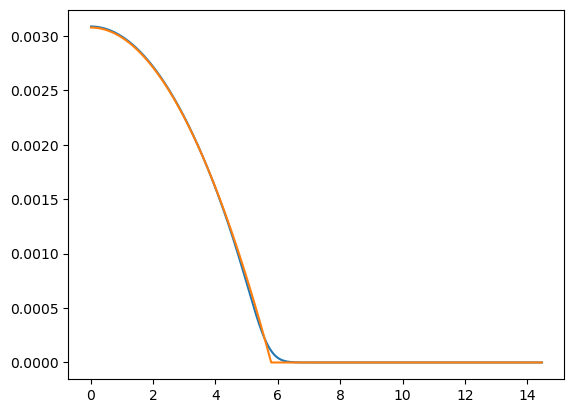

In [72]:
filename = "r_P_(As=0.00433)(N=100000)(dt=0.0001)(dr=0.01)(rmax=14.469577150116626)(tol=1e-06).dat"
with open(filename) as f:
    lines = f.readlines()
    r = np.array([line.split()[0] for line in lines],dtype=float)
    P = np.array([line.split()[1] for line in lines], dtype=float)

N=100000
psi = (P/r)/np.sqrt(4.*pi)

As=0.00433 #s-wave scattering length. For As=0 we recover the known ground state solution of the quantum h.o
g = 4.*pi*As*N #interaction strength
dt = 1e-4 #timestep
dr=0.01 #grid spacing
#be careful for what values of dt and dr you choose, since some of them may yield numerical instabilities

#Thomas-Fermi parameters muTF and rTF
muTF = 0.5*(15*As*N)**(2./5.)
rTF = np.sqrt(2.*muTF)
# print("Thomas-Fermi length is: ", rTF)

r_max = 14.469577150116626

Ngrid = int(r_max/dr)
r = np.linspace(0.,r_max,Ngrid+1)[1:] #we avoid r=0

#harmonic potential
V = 0.5*(r**2.)

#We determine the Thomas Fermi density function
TFdens = np.where(r<rTF, (muTF-0.5*r**2.)/g, 0.) 
TFdens /= simps(4.*pi*TFdens*r**2,r)

plt.plot(r,np.abs(psi)**2,label='Numerical solution')
plt.plot(r,TFdens,label='tf')
plt.show()


filename3 = "r_P_densTF(As=0.00433)(N=100000)(dt=0.0001)(dr=0.01)(rmax=14.469577150116626)(tol=1e-06).dat"
f = open(filename3,'w')
for i in range(len(r)):
    f.write(str(r[i])+" "+str(P[i])+" "+str(TFdens[i]))
    f.write("\n")